## Data Preparation

The data preparation part for this problem is the same (code is improved) as the last question. Here I need to collect the turnstile information of 2011, 2012 and 2013.

In [1]:
import numpy as np
import bisect
import datetime
station_name = {}
fp = open("Remote-Booth-Station.csv", 'r')
for line in fp:
    line = line.strip().split(',')
    station_name['%s_%s' % (line[1], line[0])] = line[2]
fp.close()


class turnstile:
    days_per_year = 365
    blocks_per_day = 6
    nan = False
    __overall_nanPercentage__ = 0.5  # less than 50% valid log, this turnstile will be ignored in further calculation
    __oneblock_nanPercentage__ = 0.2  # less than 20% valid log in a time block, the NaN days will be given value 0
    __max_possible__ = 50000  # max possible passengers to exit/enter this turnstile
    __max_downtime__ = 86400  # missing value longer then two days, won't do interpolations
    __data_exception_times__ = 10.0  # if one value is 10 times larger than its average value, abandon this data
    def __init__(self, line_list, year):
        __temp_line1__ = line_list[0].split(',')
        self.year = year
        self.days_per_year = (datetime.datetime(year+1, 1, 1)-datetime.datetime(year,1,1)).days
        self.CA = __temp_line1__[0]
        self.UNIT = __temp_line1__[1]
        self.SCP = __temp_line1__[2]
        self.ENTRY = self.get_raw_entry(line_list)
        self.EXIT = self.get_raw_exit(line_list)
        self.entry_sum = np.sum(self.ENTRY)
        self.exit_sum = np.sum(self.EXIT)
        self.busyness = self.entry_sum + self.exit_sum
        self.station_name = self.get_station_name()

    def get_station_name(self):
        station_code = self.CA + '_' + self.UNIT
        if station_code in station_name:
            return station_name[station_code]
        else:
            return "Unknown"

    def get_cumu_list(self, raw_list):
        list_cum = np.zeros(self.days_per_year * self.blocks_per_day + 1, dtype=float)
        list_cum.fill(np.NaN)
        init_time = '%d-01-01 00:00:00' % self.year
        end_time = '%d-01-01 00:00:00' % (self.year + 1)
        temp_time = datetime.datetime.strptime(init_time, '%Y-%m-%d %H:%M:%S')
        count = 0
        while str(temp_time) <= end_time:
            neigh = bisect.bisect(raw_list, str(temp_time))
            inter_val = self.GetInterpT_V(raw_list[neigh - 1: neigh + 1], temp_time)
            list_cum[count] = inter_val
            count += 1
            temp_time += datetime.timedelta(hours=4)
        return self.get_delta_list(list_cum)

    def GetInterpT_V(self, timeab, temp_time):
        # timeab = ["time1val1", "time2val2"]
        if len(timeab) < 2:
            return np.NaN
        time2, value2 = timeab[1].split(',')
        if str(temp_time) == time2:
            return int(value2)
        time1, value1 = timeab[0].split(',')
        if str(temp_time) == time1:
            return int(value1)
        if value1 == '' or value2 == '':
            return np.NaN
        if value1 == value2:
            return int(value1)
        value1, value2 = int(value1), int(value2)
        if value2 < value1:
            return np.NaN
        time1 = datetime.datetime.strptime(time1, '%Y-%m-%d %H:%M:%S')
        time2 = datetime.datetime.strptime(time2, '%Y-%m-%d %H:%M:%S')
        time1 = (temp_time - time1).total_seconds()
        time2 = (time2 - temp_time).total_seconds()
        if time1 > self.__max_downtime__ or time2 > self.__max_downtime__:
            return np.NaN
        inter_value = value1 + (value2-value1) * float(time1) / (time1+time2)
        # two-point linear interpolation
        return int(inter_value)

    def get_delta_list(self, cum_list):
        delta_list = np.ndarray((self.days_per_year, self.blocks_per_day), dtype=float)
        delta_list.fill(np.NaN)
        nan_count = 0
        for i in xrange(self.days_per_year):
            for j in xrange(self.blocks_per_day):
                index_in_cum = i*self.blocks_per_day+j
                if np.isnan(cum_list[index_in_cum]) or np.isnan(cum_list[index_in_cum+1]):
                    delta_list[i, j] = np.NaN
                    nan_count += 1
                else:
                    delta = cum_list[index_in_cum+1] - cum_list[index_in_cum]
                    if delta < 0 or delta > self.__max_possible__:
                        delta_list[i, j] = np.NaN
                        nan_count += 1
                    else:
                        delta_list[i, j] = delta
        self.down_blocks = nan_count
        if float(nan_count) / (self.days_per_year * self.blocks_per_day) > self.__overall_nanPercentage__:
            self.nan = True
        for j in xrange(self.blocks_per_day):
            valid_values = [x for x in delta_list[:, j] if not np.isnan(x)]
            if len(valid_values) == 0:
                    delta_list[:, j] = 0
                    continue
            col_mean = np.mean(valid_values)
            for i in xrange(self.days_per_year):
                if np.isnan(delta_list[i, j]):
                    if float(len(valid_values)) / self.days_per_year < self.__oneblock_nanPercentage__:
                        delta_list[i, j] = 0
                    else:
                        delta_list[i, j] = col_mean
                if delta_list[i, j] > col_mean * self.__data_exception_times__:
                    valid_len = len(valid_values) - 1
                    delta_list[i, j] = (col_mean*(valid_len+1) - delta_list[i, j])/valid_len
        delta_list_int = np.ndarray((self.days_per_year, self.blocks_per_day), dtype=int)
        for i in xrange(self.days_per_year):
            for j in xrange(self.blocks_per_day):
                delta_list_int[i][j] = int(delta_list[i][j])
        return delta_list_int

    def get_raw_entry(self, line_list):
        raw_entry_list = []
        for logs in line_list:
            log = logs.split(',')
            if len(log) < 7:
                continue
            raw_entry_list.append('%s %s,%s' % (log[3], log[4], log[5]))
        return self.get_cumu_list(raw_entry_list)

    def get_raw_exit(self, line_list):
        raw_exit_list = []
        for logs in line_list:
            log = logs.split(',')
            if len(log) < 7:
                continue
            raw_exit_list.append('%s %s,%s' % (log[3], log[4], log[6]))
        return self.get_cumu_list(raw_exit_list)
    
    def __str__(self):
        return '%s_%s_%s %d %s' % (self.CA, self.UNIT, self.SCP, self.business, self.station_name)

In [2]:
import os
def split_log_lines2(input_filename, raw_data_list):
    fp = open(input_filename, 'r')
    for line in fp:
        dat = line.strip().split(',')
        if len(dat)==11:
            date_temp = dat[6].split('/')
            dat[6] = '-'.join(date_temp[2:] + date_temp[0: 2])
            if dat[10] != 'EXITS':
                raw_data_list.append(','.join(dat[0:3] + dat[6:8] + dat[9:11]))
        else:
            for i in range(3, len(dat), 5):
                date_temp = dat[i].split('-')
                dat[i] = '20' + '-'.join(date_temp[2: 3] + date_temp[0: 2])
                raw_data_list.append(','.join(dat[0:3] + dat[i:i + 2] + dat[i + 3:i + 5]))
    fp.close()
def raw_data_list_f(year):
    file_head = 'turnstile_%d' % (year%2000)
    file_head1 = 'turnstile_%d' % (year%2000 + 1)
    raw_data_list = []
    logs_txt = [filename for filename in os.listdir(
        './') if filename.find('.txt') >= 0]
    logs_txt.sort()
    logs_y = [filename for filename in logs_txt if filename.find(file_head) >= 0]
    logs_y.append(logs_txt[bisect.bisect(logs_txt, file_head1)])
    # print logs_y
    for filename in logs_y:
        split_log_lines2(filename, raw_data_list)
    raw_data_list.sort()
    return raw_data_list
def turns_f(raw_data_list,year):
    turns = {}
    curr_turn = raw_data_list[0].split(',')
    turn_start_index = 0
    for i in xrange(len(raw_data_list)):
        line = raw_data_list[i].split(',')
        if line[0] != curr_turn[0] or line[1] != curr_turn[1] or line[2] != curr_turn[2]:
            turns['_'.join(curr_turn[0:3])] = turnstile(raw_data_list[turn_start_index: i], year)
            turn_start_index = i
            if line[1] != curr_turn[1] and line[0] != curr_turn[0] and np.random.random() < 0.1:
                print '{percent:.1%}'.format(percent=float(i)/len(raw_data_list)),
            curr_turn = line
    return turns

In [3]:
raw_data_list11=raw_data_list_f(2011)
turns11=turns_f(raw_data_list11,2011)

raw_data_list12=raw_data_list_f(2012)
turns12=turns_f(raw_data_list12,2012)

raw_data_list13=raw_data_list_f(2013)
turns13=turns_f(raw_data_list13,2013)

1.3% 4.8% 5.6% 6.5% 6.7% 6.9% 8.9% 9.0% 11.3% 14.0% 14.5% 16.1% 17.2% 19.1% 20.7% 21.0% 27.2% 28.3% 29.1% 32.0% 32.1% 32.6% 34.1% 35.8% 39.6% 48.6% 52.4% 52.8% 53.1% 57.5% 67.9% 70.3% 71.1% 71.3% 71.8% 83.7% 86.0% 86.8% 87.4% 88.7% 89.5% 90.3% 90.8% 92.5% 94.6% 97.3% 99.9% 0.5% 0.9% 1.6% 2.3% 3.2% 5.9% 6.1% 12.9% 15.7% 17.1% 18.0% 19.5% 20.6% 28.1% 31.1% 33.5% 33.6% 34.0% 34.2% 34.6% 41.1% 43.0% 44.6% 47.7% 50.3% 54.5% 56.5% 62.0% 62.6% 63.6% 64.9% 68.6% 69.7% 69.9% 71.2% 73.6% 78.3% 83.2% 87.2% 90.2% 92.1% 93.7% 94.8% 1.3% 5.3% 6.3% 6.4% 6.8% 7.7% 10.6% 11.0% 11.2% 12.7% 13.3% 15.4% 18.4% 18.7% 19.2% 20.3% 20.9% 21.8% 22.7% 24.4% 29.2% 29.6% 30.8% 31.3% 32.6% 32.9% 33.8% 40.6% 41.8% 42.1% 43.6% 51.9% 52.4% 53.0% 58.0% 61.3% 61.4% 66.3% 68.6% 68.9% 74.2% 75.3% 76.2% 78.0% 85.9% 92.0% 95.9% 96.1% 98.9%


## 1. Let’s develop a model for 4hr-interval exit count by turnstile device; What features were explored? How does this model perform?

=> 1. Events:
The event feature identify if there's a special event happens near the location of the tenstile during a certain 4 hour periord. It is categorical with 2 levels. Here, 0 means there's no event and 1 means there's an event. In this model, I hard coded the 1's according to the schedule of the baseball home game in New York. (See the solution of question 2 in detail)

=> 2. Hour: 
Includes 04:00:00,08:00:00,12:00:00,16:00:00,20:00:00,24:00:00, representing different period of a day. It is categorical with 6 levels.

=> 3. Workday: 
It includes weekday (Monday-Friday) and weekend (Saturday, Sunday and Holidays). It is categorical with 2 levels. 
The holidays (part of weekends) include: 
(1) New Year's Day, Jan.1
(2) Birthday of Martin Luther King Jr., Third Monday in Jan
(3) Washington's Birthday, Third Monday in Feb
(4) Memorial Day, Last Monday in May
(5) Independence Day, Jul.4
(6) Labor Day, First Monday in Sep
(7) Columbus Day, Second Monday in Oct
(8) Veterans Day, Nov.11
(9) Thanksgiving Day, Fourth Thursday in Nov
(10) Christmas Day, Dec.25

=> 4. WDLagComb:
It is the weekday Combination of yesterday and today. This feature represents the following 4 combinations:

  Yesterday  Today      Level
  
  Weekday   Weekday    '11'       
  Weekday   Weekend    '10'       
  Weekend   Weekend    '00'       
  Weekend   Weekday    '01' 

The levels are saved as integers, which will be converted into categoricals automatically later when fitting the linear model.

=> 5. Month:
It includes Jan, Feb, Mar, ..., December, repreenting different periods (more detailed than just 4 seasons) of a year. It is categorical with 12 levels.

=> 6. Last24HAve:
It is the average of the 6 previous data points (or the average of the last 24 hrs' count data since each data point gives the counts between the time point t and the time point t+4). It is continuous and represents the recency effect.

#### The model is: EXITS_T =  C(Workday) : C(Events) : C(Hour) + C(Month):C(Hour) + C(WDLagComb): Last24HAve + error
C(.) means the wrapped feature is categorical. I will use the data from 2011 and 2012 to train a model for each turnstile. After the models are fitted, I can do forecast for each of the tenstile. I can simply sum up the prediction for each tenstile and sum up their results if the prediction for a collection of tenstiles are required.

In [58]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn import datasets, linear_model
import statsmodels.formula.api as smf
import patsy

In [59]:
Holiday = {}
Holiday[2011] = ['01-17','02-21','05-30','07-04','09-05','10-10','11-11','11-24','12-26']
Holiday[2012] = ['01-02','01-16','02-20','05-28','07-04','09-03','10-08','11-12','11-22','12-25']
Holiday[2013] = ['01-01','01-21','02-18','05-27','07-04','09-02','10-14','11-11','11-28','12-25']
for year in Holiday:
    Holiday[year] = ['%d-%s' % (year, day) for day in Holiday[year]]

In [60]:
NYY_gamedays = []
def gameday_year(year):
    filename = 'Events%d-NYYHome.csv' % year
    fp = open(filename, 'r')
    for line in fp:
        month, day = map(lambda x: int(x), line.split(',')[1].strip('"').split('/'))
        gameday =  line.split(',')[1].strip('"')
        gameday = '%d-%2.2d-%2.2d' % (year, month, day)
        NYY_gamedays.append(gameday)
    fp.close()
gameday_year(2011)
gameday_year(2012)
gameday_year(2013)
#NYY_gamedays

In [61]:
dates = pd.date_range('01/01/2011',periods=(365+366+365)*6+1, freq='4H')
dates13 = pd.date_range('01/01/2013',periods=365*6+1, freq='4H')

In [73]:
Other_Events = [] #Other_Events are not in use in the current model.
def turns_2013fitpred(turns_name):
    if turns_name not in turns11 or turns_name not in turns12 or turns_name not in turns13:
        return pd.DataFrame([[0,0]]*len(dates13),index=dates13,columns=['EXITS_T','Pred']).ix[6:-1]
    
    exits_list11=list(turns11[turns_name].EXIT.ravel())
    exits_list12=list(turns12[turns_name].EXIT.ravel())
    exits_list13=list(turns13[turns_name].EXIT.ravel())
    exits_list13.append(0)

    exits_list=exits_list11+exits_list12+exits_list13
    
    Holidays = Holiday[2011] + Holiday[2012] + Holiday[2013]
    dta=pd.DataFrame(exits_list,index=dates)
    
    dta=pd.DataFrame(exits_list[:len(list(dates))],index=dates)
    dta.columns=['EXITS_T']
    dta['Workday']=[0 + (x.date().isoweekday() < 6 and str(x.date()) not in Holidays) for x in dates]
    dta['Events']=[0 + 1 * (str(x.date()) in NYY_gamedays) + 2 * (str(x.date()) in Other_Events) for x in dates]
    dta['Month'] = [x.month for x in dates]
    dta['Hour'] = [x.hour for x in dates]
    dta['Last24HAve'] = [0]*6 + [np.mean(dta.ix[i:i+6,0]) for i in xrange(len(dta)-6)]
    dta['WDLag']=[0]*6 + [dta.ix[i,1] for i in xrange(len(dta)-6)]
    dta['WDLagComb']=map(lambda x,y: ''.join([str(x),str(int(y))]),dta['Workday'],dta['WDLag'])
    del dta['WDLag']
    dta=dta.ix[:-1,:]
    dta=dta.ix[6:,:]
    Train=dta.ix[:(365*2+1)*6,:]
    Test=dta.ix[(365*2+1)*6:,:] 
    
    f='EXITS_T ~  C(Workday) : C(Events) : C(Hour) + C(Month):C(Hour) + WDLagComb: Last24HAve - 1'
    #res=smf.ols(formula=f, data=Train).fit() #--Comment out for pure prediction
    #print res.summary() #--Comment out for pure prediction
    
    Testy,TestX = patsy.dmatrices(f, Test, return_type='dataframe')
    Trainy,TrainX = patsy.dmatrices(f, Train, return_type='dataframe')
    regr = linear_model.LinearRegression().fit(TrainX, Trainy)
    Testy['Pred']= regr.predict(TestX)
    
    return Testy
    

In [63]:
RK=np.random.choice(turns13.keys())
RK

'R326_R389_00-00-02'

In [64]:
RK_res=turns_2013fitpred(RK)

                            OLS Regression Results                            
Dep. Variable:                EXITS_T   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     319.5
Date:                Tue, 19 Jan 2016   Prob (F-statistic):               0.00
Time:                        08:03:37   Log-Likelihood:                -15234.
No. Observations:                4386   AIC:                         3.066e+04
Df Residuals:                    4292   BIC:                         3.126e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

From the above table, we can see, for this perticular tenstile, the adjusted R-squared is 0.874, which looks good. The p-values in for most of the parameters are smaller than 0.05. ALso, since the Durbin-Watson statistic is not significantly smaller than 2, we conclude that the autocorrelation of the residuals is small with this model.

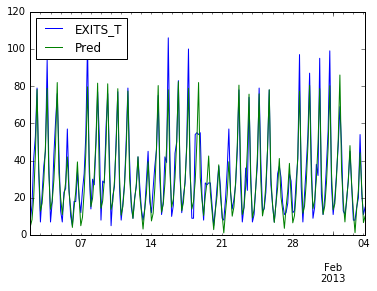

In [65]:
RK_res.ix[:200,:].plot()

The figure above shows the true values and the corresponding predictions of the selected turstile from ‘2013-01-02 00:00:00’ to ‘2013-02-04 04:00:00’.

The following gives the Mean Average Error of the prediction on the 2013 exits data on the turnsteil 'R326_R389_00-00-02', which is 5.8521125 counts every 4 hour on average. (It is found the usage of some turnstiles starting with 'N' are relatively regular, and thus easy to model and predict. We should notice the model performance for different turnstiles might be different due to their locations.)

In [66]:
from numpy import inf
a=np.array(map(lambda y1,y2: np.abs(y1-y2), RK_res.ix[:,1],RK_res.ix[:,0]))
a[a == inf] = 0
MAE=np.mean(a)
MAE

5.8521125303911603

## 2. What is our predicted exit count for R195 during the 16:00-20:00 interval on Friday September 6, 2013?

One of the most important features ('Events') can be found from the following website, which one can find the schedule of the baseball home games at the New York Yankee Stadium in 2011, 2012 and 2013. This statium is very near the R195 turnstiles.
http://newyork.yankees.mlb.com/schedule/sortable.jsp?c_id=nyy&year=2011

In [67]:
R195turns=[]
for i in turns13:
    if i.split('_')[1]=='R195':
        R195turns.append(i)
R195turns

['R262A_R195_04-00-03',
 'R262A_R195_04-00-02',
 'N203_R195_00-00-04',
 'R262_R195_03-03-02',
 'N203_R195_00-03-03',
 'N203_R195_00-03-02',
 'N203_R195_00-03-01',
 'N203_R195_00-03-00',
 'N203_R195_00-03-05',
 'N203_R195_00-03-04',
 'R262A_R195_04-00-01',
 'R262A_R195_04-00-00',
 'R262A_R195_04-00-05',
 'R262A_R195_04-00-04',
 'N205_R195_02-00-02',
 'N205_R195_02-00-03',
 'N205_R195_02-00-00',
 'N205_R195_02-00-01',
 'R262_R195_03-00-02',
 'R262_R195_03-00-00',
 'R262_R195_03-00-01',
 'N203_R195_00-00-02',
 'N203_R195_00-00-03',
 'N203_R195_00-00-00',
 'N203_R195_00-00-01',
 'N204_R195_01-00-01',
 'R262B_R195_05-00-00',
 'R262B_R195_05-00-05',
 'R262B_R195_05-00-04',
 'R262B_R195_05-00-03',
 'R262B_R195_05-00-02',
 'R262B_R195_05-00-01',
 'N203_R195_00-05-01',
 'N203_R195_00-05-00',
 'R262_R195_03-03-01',
 'R262_R195_03-06-00',
 'R262_R195_03-06-01',
 'R262_R195_03-03-00']

In [74]:
TrueY=[]
PredY=[]
for i in R195turns:
    fitpredtemp=turns_2013fitpred(i)
    TrueY.append(fitpredtemp.ix['2013-09-05 16:00',0])
    PredY.append(fitpredtemp.ix['2013-09-05 16:00',1])

In [75]:
print np.sum(TrueY)
print np.sum(PredY)

13170.0
11303.3144669


The predicted value exit count for R195 is 11303.3144669, which is a little smaller than the true value count. This is because I only set up two levels for the 'Events' feature, where the model cannot distinguish the big events from other events.